In [ ]:
import gzip
import json
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import re
from html import unescape
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

np.random.seed(42)

In [ ]:
reviews_path = 'data/raw/amazon_electronics_reviews.json.gz'
meta_path = 'data/raw/amazon_electronics_meta.json.gz'

In [ ]:
import time

def load_amazon_reviews(path, max_rows=None, sample_rate=None):
    """
    Load Amazon reviews from gzipped JSON file
    
    Parameters:
    - path: Path to reviews file
    - max_rows: Maximum rows to load (None = all)
    - sample_rate: Sample every Nth row (e.g., 10 = every 10th row)
    
    Returns:
    - DataFrame with reviews
    """
    data = []
    with gzip.open(path, 'rt', encoding='utf-8') as f:
        for i, line in enumerate(tqdm(f, desc="Loading reviews")):
            if max_rows and len(data) >= max_rows:
                break
            
            if sample_rate and i % sample_rate != 0:
                continue
            
            try:
                data.append(json.loads(line.strip()))
            except json.JSONDecodeError:
                continue
    return pd.DataFrame(data)

start_time = time.time()

df_reviews = load_amazon_reviews(reviews_path, sample_rate=10)

load_time = time.time() - start_time
print(f"\nLoaded {len(df_reviews):,} reviews in {load_time:.2f}s")
print(f"  Shape: {df_reviews.shape}")
print(f"  Columns: {df_reviews.columns.tolist()}")

Loading reviews: 1689188it [00:04, 350046.80it/s]



Loaded 168,919 reviews in 5.10s
  Shape: (168919, 9)
  Columns: ['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText', 'overall', 'summary', 'unixReviewTime', 'reviewTime']


In [18]:
import pyarrow.parquet as pq
import pandas as pd
import glob
import random

def load_parquet_sample(folder="data/meta_parquet", sample_frac=0.1, row_frac=0.1):
    files = sorted(glob.glob(f"{folder}/meta_chunk_*.parquet"))
    dfs = []

    for f in files:
        parquet = pq.ParquetFile(f)
        num_row_groups = parquet.num_row_groups

        # choose only a fraction of row groups
        n_sample = max(1, int(num_row_groups * sample_frac))
        sampled_groups = random.sample(range(num_row_groups), n_sample)

        tables = []
        for rg in sampled_groups:
            table = parquet.read_row_group(rg)
            df = table.to_pandas(ignore_metadata=True)

            # optional: sample rows within the row group
            df = df.sample(frac=row_frac)
            tables.append(df)

        if tables:
            dfs.append(pd.concat(tables, ignore_index=True))

    return pd.concat(dfs, ignore_index=True)

In [19]:
df_meta = load_parquet_sample()
print(df_meta.shape)

(49820, 9)


In [20]:
df_meta.head()

,asin,imUrl,description,categories,title,price,salesRank,related,brand
0,B000PCEG58,http://ecx.images-amazon.com/images/I/41RaLCcT...,Yamaha 7.1 Channel Digital Home Theater Receiv...,"[[Electronics, Home Audio, Stereo Components, ...",Yamaha RX-V861BL 7.1-Channel XM-Ready Home The...,41.49,"{'Arts, Crafts & Sewing': None, 'Automotive': ...","{'also_bought': None, 'also_viewed': ['B005GNW...",None
1,B000SSP2I4,http://ecx.images-amazon.com/images/I/31gMMR5-...,There are always times when our Creative xMod ...,"[[Electronics, Portable Audio & Video, MP3 Pla...",Portable Emergency AA Battery Charger Extender...,19.80,None,None,None
2,B0000A0E21,http://g-ecx.images-amazon.com/images/G/01/x-s...,None,"[[Electronics, Computers & Accessories, Laptop...",Incase Laptop Sleeve - Notebook carrying case,NaN,None,None,None
3,B000Q3QIWK,http://ecx.images-amazon.com/images/I/41ccItT5...,Cowon D2 2GB and 4GB player NOT inlcuded!!,"[[Electronics, Portable Audio & Video, MP3 Pla...",Cowon D2 2GB 4GB Portable Media Player Silicon...,NaN,None,None,None
4,B00125BHWC,http://ecx.images-amazon.com/images/I/41V3AMO9...,This battery charger replaces the Canon origin...,"[[Electronics, Camera & Photo, Accessories, Ba...",Wasabi Power Battery Charger for Canon PowerSh...,NaN,None,None,None


In [21]:
df_reviews.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,AO94DHGC771SJ,0528881469,amazdnu,"[0, 0]",We got this GPS for my husband who is an (OTR)...,5.00,Gotta have GPS!,1370131200,"06 2, 2013"
1,A7S2B0I67WNWB,0594481813,AllyMG,"[2, 2]",This item is just as was described in the orig...,4.00,As expected,1397606400,"04 16, 2014"
2,A1EDI0X3GI1SK7,0972683275,AGW,"[0, 1]","Great deal, easy to mount and it appears to be...",5.00,32 In TV Mount,1323993600,"12 16, 2011"
3,AYQNWE3AX4H08,0972683275,"arl6969 ""arl6969""","[0, 0]",this holds up my 55inch sony with ease. make s...,5.00,work great,1374105600,"07 18, 2013"
4,A27XULAA9X5ZGQ,0972683275,Branon Young,"[0, 0]",This mount is excellent. It is very well built...,5.00,Very Pleased,1329436800,"02 17, 2012"


In [22]:
print("\nReviews - Null Counts:")
null_reviews = df_reviews.isnull().sum()
null_pct_reviews = (df_reviews.isnull().sum() / len(df_reviews) * 100).round(2)
null_summary_reviews = pd.DataFrame({
    'Null Count': null_reviews,
    'Percentage': null_pct_reviews
})
print(null_summary_reviews[null_summary_reviews['Null Count'] > 0])


Reviews - Null Counts:
              Null Count  Percentage
reviewerName        2464        1.46


In [23]:
print("\nMetadata - Null Counts:")
null_meta = df_meta.isnull().sum()
null_pct_meta = (df_meta.isnull().sum() / len(df_meta) * 100).round(2)
null_summary_meta = pd.DataFrame({
    'Null Count': null_meta,
    'Percentage': null_pct_meta
})
print(null_summary_meta[null_summary_meta['Null Count'] > 0])


Metadata - Null Counts:
             Null Count  Percentage
imUrl                22        0.04
description        3858        7.74
title               656        1.32
price             10952       21.98
salesRank         36819       73.90
related           13076       26.25
brand             35622       71.50


In [24]:
print(f"\nReviews:")
print(f"  Total reviews: {len(df_reviews):,}")
dup_reviews = df_reviews.duplicated(subset=['reviewerID', 'asin']).sum()
print(f"  Duplicate (reviewerID + asin): {dup_reviews:,} ({dup_reviews/len(df_reviews)*100:.2f}%)")


Reviews:
  Total reviews: 168,919
  Duplicate (reviewerID + asin): 0 (0.00%)


In [25]:
print(f"\nMetadata:")
print(f"  Total products: {len(df_meta):,}")
dup_meta = df_meta.duplicated(subset=['asin']).sum()
print(f"  Duplicate (asin): {dup_meta:,} ({dup_meta/len(df_meta)*100:.2f}%)")


Metadata:
  Total products: 49,820
  Duplicate (asin): 0 (0.00%)


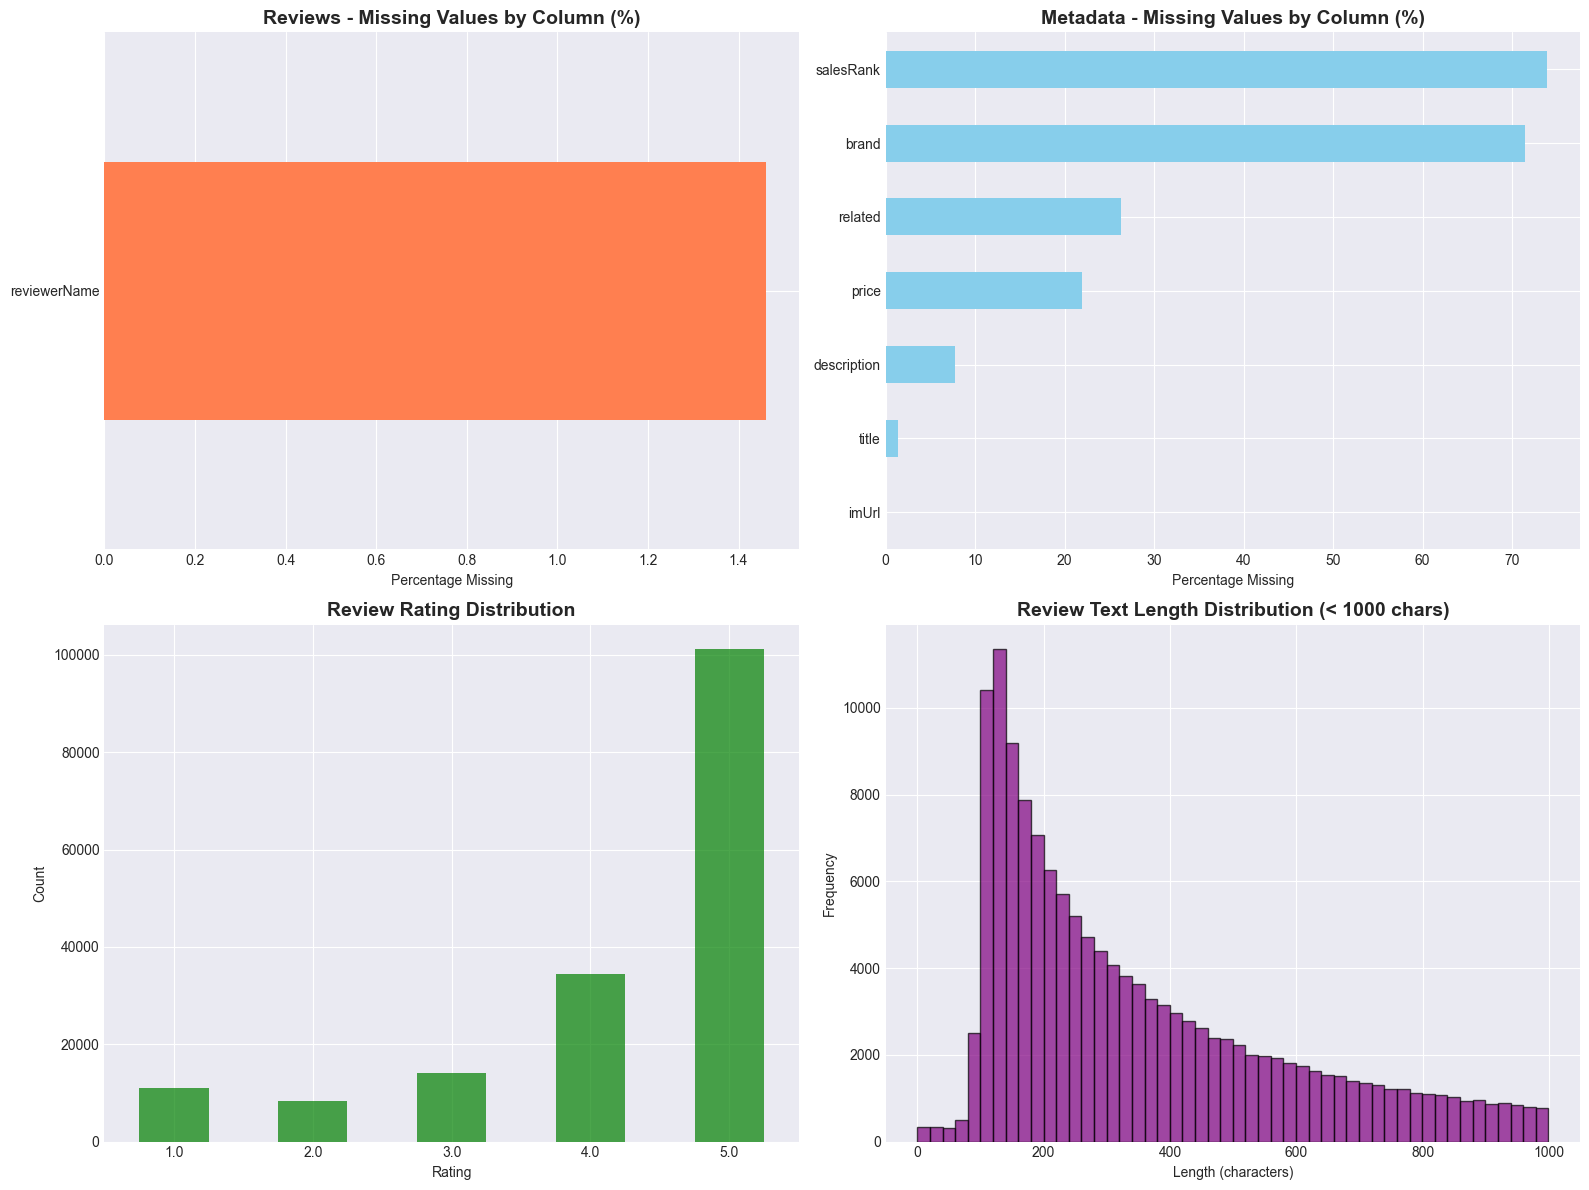

In [26]:
# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Reviews missing values
ax = axes[0, 0]
null_data = null_summary_reviews[null_summary_reviews['Null Count'] > 0]
if len(null_data) > 0:
    null_data['Percentage'].sort_values().plot(kind='barh', ax=ax, color='coral')
    ax.set_title('Reviews - Missing Values by Column (%)', fontsize=14, fontweight='bold')
    ax.set_xlabel('Percentage Missing')
else:
    ax.text(0.5, 0.5, 'No Missing Values', ha='center', va='center', fontsize=16)
    ax.set_title('Reviews - Missing Values', fontsize=14, fontweight='bold')

# Metadata missing values
ax = axes[0, 1]
null_data = null_summary_meta[null_summary_meta['Null Count'] > 0]
if len(null_data) > 0:
    null_data['Percentage'].sort_values().plot(kind='barh', ax=ax, color='skyblue')
    ax.set_title('Metadata - Missing Values by Column (%)', fontsize=14, fontweight='bold')
    ax.set_xlabel('Percentage Missing')
else:
    ax.text(0.5, 0.5, 'No Missing Values', ha='center', va='center', fontsize=16)
    ax.set_title('Metadata - Missing Values', fontsize=14, fontweight='bold')

# Rating distribution
ax = axes[1, 0]
df_reviews['overall'].value_counts().sort_index().plot(kind='bar', ax=ax, color='green', alpha=0.7)
ax.set_title('Review Rating Distribution', fontsize=14, fontweight='bold')
ax.set_xlabel('Rating')
ax.set_ylabel('Count')
ax.tick_params(axis='x', rotation=0)

# Review length distribution
ax = axes[1, 1]
review_lengths = df_reviews['reviewText'].str.len()
ax.hist(review_lengths[review_lengths < 1000], bins=50, color='purple', alpha=0.7, edgecolor='black')
ax.set_title('Review Text Length Distribution (< 1000 chars)', fontsize=14, fontweight='bold')
ax.set_xlabel('Length (characters)')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [27]:
df_reviews_clean = df_reviews.copy()
df_meta_clean = df_meta.copy()

In [28]:
# Reviews - Fill missing reviewer names
print(f"\nReviews:")
if 'reviewerName' in df_reviews_clean.columns:
    missing_names = df_reviews_clean['reviewerName'].isnull().sum()
    df_reviews_clean['reviewerName'] = df_reviews_clean['reviewerName'].fillna('Anonymous')
    print(f"  Filled {missing_names:,} missing reviewer names with 'Anonymous'")


Reviews:
  Filled 2,464 missing reviewer names with 'Anonymous'


In [ ]:
print(f"\nMetadata:")
if 'title' in df_meta_clean.columns:
    missing_titles = df_meta_clean['title'].isnull().sum()
    df_meta_clean['title'] = df_meta_clean['title'].fillna('Unknown Product')
    print(f"  Filled {missing_titles:,} missing titles with 'Unknown Product'")

if 'description' in df_meta_clean.columns:
    missing_desc = df_meta_clean['description'].isnull().sum()
    df_meta_clean['description'] = df_meta_clean['description'].fillna('')
    print(f"  Filled {missing_desc:,} missing descriptions with empty string")

if 'brand' in df_meta_clean.columns:
    missing_brand = df_meta_clean['brand'].isnull().sum()
    df_meta_clean['brand'] = df_meta_clean['brand'].fillna('Unknown')
    print(f"  Filled {missing_brand:,} missing brands with 'Unknown'")


Metadata:
  Filled 656 missing titles with 'Unknown Product'
  Filled 3,858 missing descriptions with empty string
  Filled 35,622 missing brands with 'Unknown'


In [30]:
def clean_text(text):
    """
    Clean and normalize text data
    
    Steps:
    - Unescape HTML entities
    - Remove HTML tags
    - Remove URLs
    - Normalize whitespace
    """
    if pd.isna(text) or not isinstance(text, str):
        return ""
    
    # Unescape HTML entities (&amp; -> &, &lt; -> <, etc.)
    text = unescape(text)
    
    # Remove HTML tags
    text = re.sub(r'<[^>]+>', '', text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    
    # Remove extra whitespace
    text = ' '.join(text.split())
    
    return text.strip()

In [ ]:
print("\nCleaning review text...")
df_reviews_clean['reviewText_clean'] = df_reviews_clean['reviewText'].apply(clean_text)
print(f"  Cleaned {len(df_reviews_clean):,} review texts")

df_reviews_clean['summary_clean'] = df_reviews_clean['summary'].apply(clean_text)
print(f"  Cleaned {len(df_reviews_clean):,} review summaries")


Cleaning review text...
  Cleaned 168,919 review texts
  Cleaned 168,919 review summaries


In [ ]:
print("\nCleaning product descriptions...")
df_meta_clean['description_clean'] = df_meta_clean['description'].apply(clean_text)
print(f"  Cleaned {len(df_meta_clean):,} product descriptions")

df_meta_clean['title_clean'] = df_meta_clean['title'].apply(clean_text)
print(f"  Cleaned {len(df_meta_clean):,} product titles")


Cleaning product descriptions...
  Cleaned 49,820 product descriptions
  Cleaned 49,820 product titles


In [33]:
df_meta_clean['categories'].head(20).tolist()

[array([array(['Electronics', 'Home Audio', 'Stereo Components',
               'Receivers & Amplifiers', 'Component Receivers'], dtype=object)],
       dtype=object),
 array([array(['Electronics', 'Portable Audio & Video',
               'MP3 Players & Accessories', 'MP3 Player Accessories', 'Chargers',
               'Battery Packs'], dtype=object)                                   ],
       dtype=object),
 array([array(['Electronics', 'Computers & Accessories',
               'Laptop & Netbook Computer Accessories', 'Bags & Cases',
               'Sleeves & Slipcases'], dtype=object)                   ],
       dtype=object),
 array([array(['Electronics', 'Portable Audio & Video',
               'MP3 Players & Accessories', 'MP3 Player Accessories', 'Cases'],
              dtype=object)                                                    ],
       dtype=object),
 array([array(['Electronics', 'Camera & Photo', 'Accessories',
               'Batteries & Chargers', 'Battery Chargers', '

In [34]:
import ast

def fix_categories(x):
    if isinstance(x, str):
        try:
            return ast.literal_eval(x)
        except:
            return []
    return x


In [35]:
df_meta_clean['categories'] = df_meta_clean['categories'].apply(fix_categories)

In [ ]:
import numpy as np

def extract_main_category(categories):
    if categories is None:
        return "Unknown"

    if isinstance(categories, np.ndarray):
        if len(categories) == 0:
            return "Unknown"

        inner = categories[0]

        if isinstance(inner, np.ndarray):
            if len(inner) >= 2:
                return inner[1]
            elif len(inner) >= 1:
                return inner[0]

    return "Unknown"


def extract_subcategory(categories):
    if categories is None:
        return "Unknown"

    if isinstance(categories, np.ndarray):
        if len(categories) == 0:
            return "Unknown"

        inner = categories[0]

        if isinstance(inner, np.ndarray) and len(inner) >= 3:
            return inner[2]

    return "Unknown"


In [ ]:
df_meta_clean['main_category'] = df_meta_clean['categories'].apply(extract_main_category)
df_meta_clean['subcategory'] = df_meta_clean['categories'].apply(extract_subcategory)

print(f"\n Extracted categories for {len(df_meta_clean):,} products")
print(f"  Unique main categories: {df_meta_clean['main_category'].nunique()}")
print(f"  Unique subcategories: {df_meta_clean['subcategory'].nunique()}")


 Extracted categories for 49,820 products
  Unique main categories: 22
  Unique subcategories: 118


In [38]:
print(f"\nTop 10 Main Categories:")
print(df_meta_clean['main_category'].value_counts().head(10))


Top 10 Main Categories:
main_category
Computers & Accessories        23105
Camera & Photo                  9624
Accessories & Supplies          6598
Portable Audio & Video          3540
Car & Vehicle Electronics       2599
Television & Video              1188
Home Audio                       968
GPS & Navigation                 692
eBook Readers & Accessories      636
Security & Surveillance          440
Name: count, dtype: int64


In [39]:
print(f"\nTotal reviews: {len(df_reviews_clean):,}")
print(f"Unique reviewers: {df_reviews_clean['reviewerID'].nunique():,}")
print(f"Unique products: {df_reviews_clean['asin'].nunique():,}")
print(f"Date range: {df_reviews_clean['reviewTime'].min()} to {df_reviews_clean['reviewTime'].max()}")


Total reviews: 168,919
Unique reviewers: 104,974
Unique products: 53,250
Date range: 01 1, 2003 to 12 9, 2013


In [40]:
print(f"\nRating Statistics:")
print(df_reviews_clean['overall'].describe())


Rating Statistics:
count   168919.00
mean         4.22
std          1.19
min          1.00
25%          4.00
50%          5.00
75%          5.00
max          5.00
Name: overall, dtype: float64


In [41]:
print(f"\nRating Distribution:")
print(df_reviews_clean['overall'].value_counts().sort_index())


Rating Distribution:
overall
1.00     10988
2.00      8240
3.00     14139
4.00     34414
5.00    101138
Name: count, dtype: int64


In [42]:
print(f"\nReview Length Statistics (characters):")
review_lengths = df_reviews_clean['reviewText_clean'].str.len()
print(f"  Mean: {review_lengths.mean():.0f}")
print(f"  Median: {review_lengths.median():.0f}")
print(f"  Max: {review_lengths.max():.0f}")


Review Length Statistics (characters):
  Mean: 632
  Median: 340
  Max: 32183


In [43]:
print(f"\nTotal products: {len(df_meta_clean):,}")
print(f"Products with price: {df_meta_clean['price'].notna().sum():,} ({df_meta_clean['price'].notna().sum()/len(df_meta_clean)*100:.2f}%)")
print(f"Products with brand: {df_meta_clean['brand'].notna().sum():,} ({df_meta_clean['brand'].notna().sum()/len(df_meta_clean)*100:.2f}%)")
print(f"Products with description: {(df_meta_clean['description_clean'].str.len() > 0).sum():,}")


Total products: 49,820
Products with price: 38,868 (78.02%)
Products with brand: 49,820 (100.00%)
Products with description: 44,193


In [44]:
print(f"\nPrice Statistics:")
print(df_meta_clean['price'].describe())


Price Statistics:
count   38868.00
mean       61.17
std       118.20
min         0.01
25%         9.95
50%        19.99
75%        52.99
max       999.99
Name: price, dtype: float64


In [45]:
print(f"\nTop 10 Brands:")
print(df_meta_clean['brand'].value_counts().head(10))


Top 10 Brands:
brand
Unknown      35970
HP             216
Sony           209
Neewer         195
Generic        180
Monoprice      159
Dell           138
eForCity       125
SIB-CORP       121
Samsung        120
Name: count, dtype: int64


In [46]:
print(f"\nTotal main categories: {df_meta_clean['main_category'].nunique()}")
print(f"Total subcategories: {df_meta_clean['subcategory'].nunique()}")

print(f"\nTop 15 Main Categories:")
category_counts = df_meta_clean['main_category'].value_counts().head(15)
for cat, count in category_counts.items():
    pct = count / len(df_meta_clean) * 100
    print(f"  {cat}: {count:,} ({pct:.2f}%)")


Total main categories: 22
Total subcategories: 118

Top 15 Main Categories:
  Computers & Accessories: 23,105 (46.38%)
  Camera & Photo: 9,624 (19.32%)
  Accessories & Supplies: 6,598 (13.24%)
  Portable Audio & Video: 3,540 (7.11%)
  Car & Vehicle Electronics: 2,599 (5.22%)
  Television & Video: 1,188 (2.38%)
  Home Audio: 968 (1.94%)
  GPS & Navigation: 692 (1.39%)
  eBook Readers & Accessories: 636 (1.28%)
  Security & Surveillance: 440 (0.88%)
  Cases: 152 (0.31%)
  Electronics Warranties: 140 (0.28%)
  Accessories: 114 (0.23%)
  Service & Replacement Plans: 9 (0.02%)
  Cell Phones: 5 (0.01%)


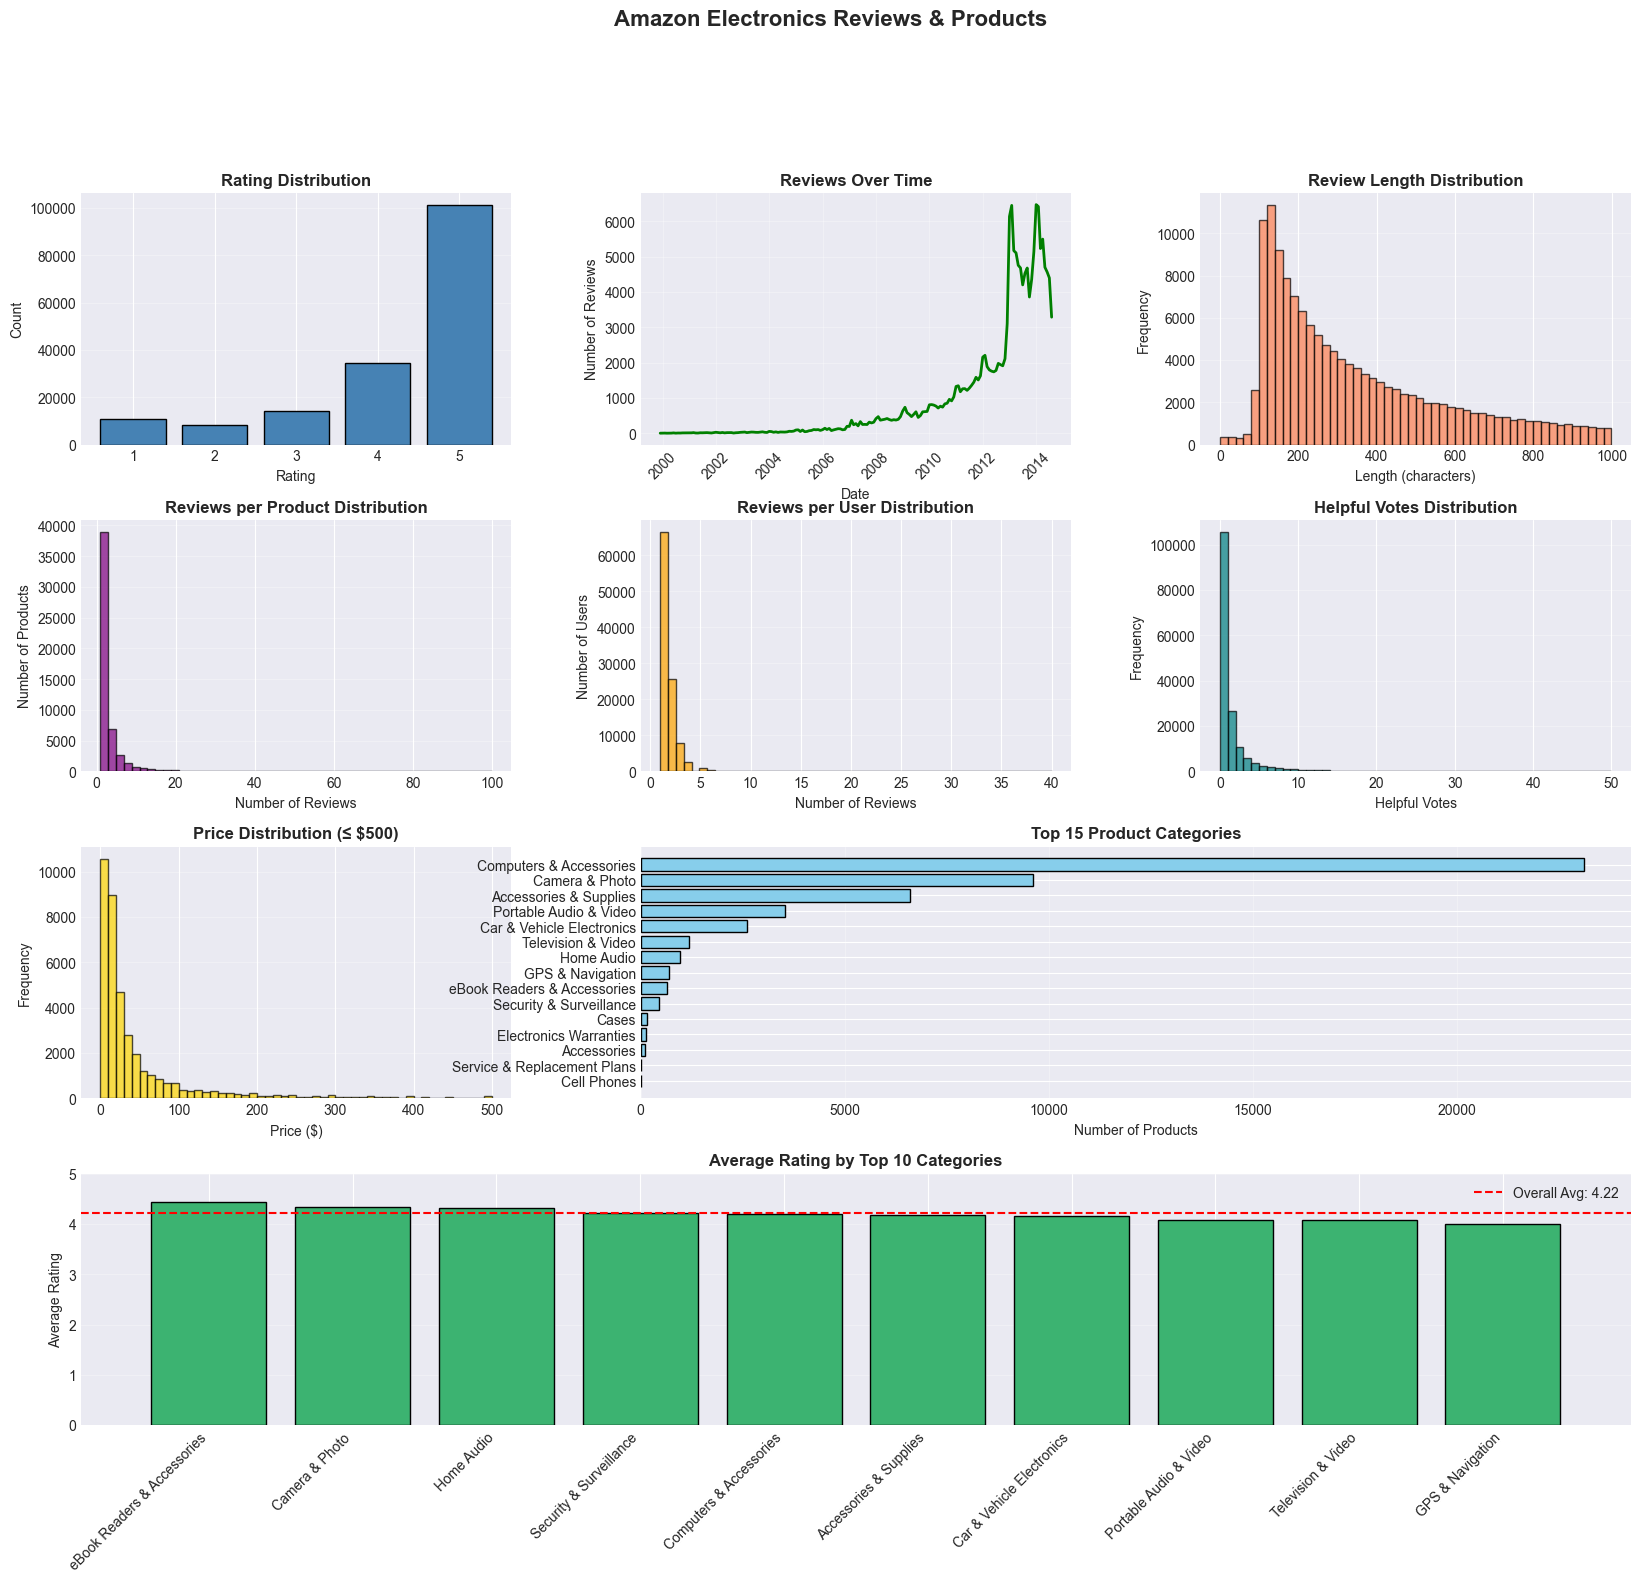

In [48]:
# Create comprehensive EDA visualizations
fig = plt.figure(figsize=(20, 16))
gs = fig.add_gridspec(4, 3, hspace=0.3, wspace=0.3)

# 1. Rating distribution
ax = fig.add_subplot(gs[0, 0])
rating_counts = df_reviews_clean['overall'].value_counts().sort_index()
ax.bar(rating_counts.index, rating_counts.values, color='steelblue', edgecolor='black')
ax.set_title('Rating Distribution', fontsize=12, fontweight='bold')
ax.set_xlabel('Rating')
ax.set_ylabel('Count')
ax.grid(axis='y', alpha=0.3)

# 2. Reviews over time
ax = fig.add_subplot(gs[0, 1])
df_reviews_clean['reviewTime_dt'] = pd.to_datetime(df_reviews_clean['reviewTime'], format='%m %d, %Y')
reviews_by_month = df_reviews_clean.set_index('reviewTime_dt').resample('M').size()
ax.plot(reviews_by_month.index, reviews_by_month.values, color='green', linewidth=2)
ax.set_title('Reviews Over Time', fontsize=12, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Number of Reviews')
ax.grid(alpha=0.3)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

# 3. Review length distribution
ax = fig.add_subplot(gs[0, 2])
review_lengths = df_reviews_clean['reviewText_clean'].str.len()
ax.hist(review_lengths[review_lengths < 1000], bins=50, color='coral', edgecolor='black', alpha=0.7)
ax.set_title('Review Length Distribution', fontsize=12, fontweight='bold')
ax.set_xlabel('Length (characters)')
ax.set_ylabel('Frequency')
ax.grid(axis='y', alpha=0.3)

# 4. Reviews per product distribution
ax = fig.add_subplot(gs[1, 0])
reviews_per_product = df_reviews_clean['asin'].value_counts()
ax.hist(reviews_per_product[reviews_per_product <= 100], bins=50, color='purple', edgecolor='black', alpha=0.7)
ax.set_title('Reviews per Product Distribution', fontsize=12, fontweight='bold')
ax.set_xlabel('Number of Reviews')
ax.set_ylabel('Number of Products')
ax.grid(axis='y', alpha=0.3)

# 5. Reviews per user distribution
ax = fig.add_subplot(gs[1, 1])
reviews_per_user = df_reviews_clean['reviewerID'].value_counts()
ax.hist(reviews_per_user[reviews_per_user <= 50], bins=50, color='orange', edgecolor='black', alpha=0.7)
ax.set_title('Reviews per User Distribution', fontsize=12, fontweight='bold')
ax.set_xlabel('Number of Reviews')
ax.set_ylabel('Number of Users')
ax.grid(axis='y', alpha=0.3)

# 6. Helpful votes distribution
ax = fig.add_subplot(gs[1, 2])
if 'helpful' in df_reviews_clean.columns:
    helpful_counts = df_reviews_clean['helpful'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else 0)
    ax.hist(helpful_counts[helpful_counts <= 50], bins=50, color='teal', edgecolor='black', alpha=0.7)
    ax.set_title('Helpful Votes Distribution', fontsize=12, fontweight='bold')
    ax.set_xlabel('Helpful Votes')
    ax.set_ylabel('Frequency')
    ax.grid(axis='y', alpha=0.3)

# 7. Price distribution
ax = fig.add_subplot(gs[2, 0])
prices = df_meta_clean['price'].dropna()
ax.hist(prices[prices <= 500], bins=50, color='gold', edgecolor='black', alpha=0.7)
ax.set_title('Price Distribution (≤ $500)', fontsize=12, fontweight='bold')
ax.set_xlabel('Price ($)')
ax.set_ylabel('Frequency')
ax.grid(axis='y', alpha=0.3)

# 8. Top categories
ax = fig.add_subplot(gs[2, 1:])
top_cats = df_meta_clean['main_category'].value_counts().head(15)
ax.barh(range(len(top_cats)), top_cats.values, color='skyblue', edgecolor='black')
ax.set_yticks(range(len(top_cats)))
ax.set_yticklabels(top_cats.index)
ax.set_title('Top 15 Product Categories', fontsize=12, fontweight='bold')
ax.set_xlabel('Number of Products')
ax.grid(axis='x', alpha=0.3)
ax.invert_yaxis()

# 9. Rating by category (top 10 categories)
ax = fig.add_subplot(gs[3, :])
top_10_cats = df_meta_clean['main_category'].value_counts().head(10).index
df_merged_temp = df_reviews_clean.merge(df_meta_clean[['asin', 'main_category']], on='asin', how='left')
df_merged_temp_top = df_merged_temp[df_merged_temp['main_category'].isin(top_10_cats)]
category_ratings = df_merged_temp_top.groupby('main_category')['overall'].mean().sort_values(ascending=False)
ax.bar(range(len(category_ratings)), category_ratings.values, color='mediumseagreen', edgecolor='black')
ax.set_xticks(range(len(category_ratings)))
ax.set_xticklabels(category_ratings.index, rotation=45, ha='right')
ax.set_title('Average Rating by Top 10 Categories', fontsize=12, fontweight='bold')
ax.set_ylabel('Average Rating')
ax.set_ylim(0, 5)
ax.axhline(y=df_reviews_clean['overall'].mean(), color='red', linestyle='--', label=f'Overall Avg: {df_reviews_clean["overall"].mean():.2f}')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.suptitle('Amazon Electronics Reviews & Products', fontsize=16, fontweight='bold', y=0.995)
plt.show()

In [49]:
# Merge on ASIN (product ID)
df_merged = df_reviews_clean.merge(
    df_meta_clean[['asin', 'title_clean', 'description_clean', 'price', 'brand', 
                   'main_category', 'subcategory']],
    on='asin',
    how='left'
)

print(f"\n Merged dataset created")
print(f"  Total records: {len(df_merged):,}")
print(f"  Records with product info: {df_merged['title_clean'].notna().sum():,} ({df_merged['title_clean'].notna().sum()/len(df_merged)*100:.2f}%)")
print(f"  Shape: {df_merged.shape}")


 Merged dataset created
  Total records: 168,919
  Records with product info: 16,861 (9.98%)
  Shape: (168919, 18)


In [ ]:
display(df_merged[['reviewerID', 'asin', 'overall', 'title_clean', 'main_category', 'price']].head())

,reviewerID,asin,overall,title_clean,main_category,price
0,AO94DHGC771SJ,0528881469,5.00,NaN,NaN,NaN
1,A7S2B0I67WNWB,0594481813,4.00,NaN,NaN,NaN
2,A1EDI0X3GI1SK7,0972683275,5.00,NaN,NaN,NaN
3,AYQNWE3AX4H08,0972683275,5.00,NaN,NaN,NaN
4,A27XULAA9X5ZGQ,0972683275,5.00,NaN,NaN,NaN


In [ ]:
df_fakestore = pd.read_csv('data/raw/fakestore_products.csv')
df_interactions = pd.read_csv('data/raw/user_interactions.csv')

print(f"  Products: {len(df_fakestore):,}")
print(f"  User interactions: {len(df_interactions):,}")

df_merged['data_source'] = 'Amazon'
df_fakestore['data_source'] = 'FakeStore'

  Products: 20
  User interactions: 5,000


In [53]:
import os
os.makedirs('data/processed', exist_ok=True)

# 1. Cleaned reviews
df_reviews_clean.to_csv('data/processed/amazon_reviews_cleaned.csv', index=False)

# 2. Cleaned metadata
df_meta_clean.to_csv('data/processed/amazon_metadata_cleaned.csv', index=False)

# 3. Merged dataset
df_merged.to_csv('data/processed/amazon_reviews_with_metadata.csv', index=False)